In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.interpolate as interpolate
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline, interp1d
from tqdm import tqdm 
from catmul_rom_spline import *
import math
from skimage.io import imread
from utilities import *
import scipy.ndimage as ndi
import tps_utils as TPS
import random 


## create test data and interpolation 

In [2]:
"""p1 = np.asarray(pickle.load(open("/Users/ranjak/Downloads/jaxreg/all_pts.pkl", "rb"))).T[1:,:]
p2 = np.asarray(pickle.load(open("/Users/ranjak/Downloads/jaxreg/ref_pts.pkl", "rb"))).T[1:,:]"""

p1 = pickle.load(open("/Users/ranjak/thesis/ref_pts.pkl", "rb")).T[3:]
p2 = pickle.load(open("/Users/ranjak/thesis/dapi_pts.pkl", "rb")).T[3:]

In [3]:
fix = imread("/Users/ranjak/Downloads/jaxreg/syn/fix1.png")
mov = imread("/Users/ranjak/Downloads/jaxreg/syn/mov1.png")

In [4]:
def plot_points(p1, p2):
    f, a = plt.subplots(1, 3, figsize = (12, 4))
    a[0].invert_yaxis()
    a[0].scatter(p1[:, 0], p1[:, 1], c = "r")
    a[0].set_axis_off()
    a[1].invert_yaxis()
    a[1].scatter(p2[:, 0], p2[:, 1], c = "y")
    a[1].set_axis_off()
    a[2].invert_yaxis()
    a[2].scatter(p2[:, 0], p2[:, 1], c = "y")
    a[2].scatter(p1[:, 0], p1[:, 1], c = "r")
    a[2].set_axis_off()
    plt.show()

In [5]:
p1_x, p1_y = p1[:, 0], p1[:, 1]
p2_x, p2_y = p2[:, 0], p2[:, 1]


In [6]:
xmin = min(min(p1_x), min(p2_x))
xmax = max(max(p1_x), max(p2_x))

In [7]:
#Define alpha
a=0.
npts = 10
# Calculate the Catmull-Rom splines through the points
c1 = CatmullRomChain(p1,a, npts)
c2 = CatmullRomChain(p2,a, npts)

p1_int = np.asarray([(x1, y1) for x1, y1 in c1])
p2_int = np.asarray([(x1, y1) for x1, y1 in c2])

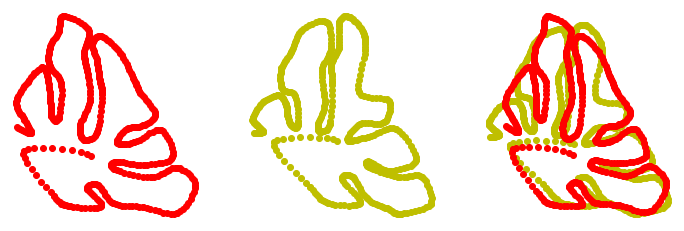

In [8]:
plot_points(p1_int, p2_int)

In [9]:
p1_int, p2_int =  get_unique_elements(p1_int), get_unique_elements(p2_int)

NameError: name 'get_unique_elements' is not defined

## solve dp for curve matching 

In [220]:
def get_psi(ds1, ds2):
    """
    given the two ds segments computes the cosine and sine of the angle between the matching 
    """
    hyp = (ds1**2 + ds2**2)**0.5
    cos_psi = ds1 / hyp
    sin_psi = ds2 / hyp
    
    return cos_psi, sin_psi
    
def get_delta_s(p1, p2):
    """
    computes the ds between two points on a curve 
    """
    x1, y1 = p1
    x2, y2 = p2
    ds = ((x1-x2)**2 + (y1-y2)**2)**0.5
    return ds

def get_kappa_and_derivatives(a):
    """
    returns the curvature and gradients of a curve segment 
    """
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    return curvature, [dx_dt, dy_dt, d2x_dt2, d2y_dt2] 


def get_segments_from_pt_list(p1):
    seg_list = []
    curv_list = []
    for i in range(1, len(p1)):
        strt = p1[i-1]
        end  = p1[i]
        ds   = get_delta_s(strt, end)
        seg_list.append(ds)
        
    return seg_list

def get_unique_elements(p1):
    """
    returns only unique pts from the pt list 
    """
    pint = []
    pset = set()
    for pi in p1:
        if (pi[0], pi[1]) in pset:
            pass
        else:
            pint.append(pi)
            pset.add((pi[0], pi[1]))
    return np.asarray(pint)
    
def get_tup_list(i, j):
    """
    get valid tup list from all possible tuples 
    """
    str_tup_list = [(i, i), (i-1, i), (i-1, i), (i-2, i), (i-3, i), (i-3, i), (i-2, i), (i-1, i), (i-1, i)]
    end_tup_list = [(j-1, j), (j, j), (j-1, j), (j-1, j), (j-1, j), (j-2, j), (j-3, j), (j-3, j), (j-2, j)]
    s1_list = []
    s2_list = []
    for (str_tup, end_tup) in zip(str_tup_list, end_tup_list):
        s1, s2 = str_tup
        u1, u2 = end_tup
        if s1<0 or s2<0 or u1<0 or u2<0:
            pass
        else:
            s1_list.append(str_tup)
            s2_list.append(end_tup)
    
    return s1_list, s2_list
        

def plot_cost_map(i, j, p1_int, p2_int):
    
    """
    plots the possible cost maps of the decision to be taken from i, j 
    """

    s1_list, s2_list = get_tup_list(i, j)

    for (str_tup, end_tup) in zip(s1_list, s2_list):
        i1, i2 = str_tup  ## here we match the segments i1-i2 in the first curve with j1-j2 in the second curve 
        j1, j2 = end_tup 
        #
        print (f"{i1} to  {i2} in curve 1")
        print (f"{j1} to  {j2} in curve 2 ")
        p1_pts = p1_int[i1:i2+1]  ## these will be the corresponding pts in both the curve 
        p2_pts = p2_int[j1:j2+1]

        f, a  = plt.subplots(1, 2, figsize = (12, 8))
        a[0].scatter(p1_int[:, 0], p1_int[:, 1], c = "b")   ## i is blue 
        a[1].scatter(p2_int[:, 0], p2_int[:, 1], c = "y")   ## j is yellow 
        a[0].plot(p1_int[:, 0], p1_int[:, 1])
        a[0].set_axis_off()
        a[1].set_axis_off()
        a[1].plot(p2_int[:, 0], p2_int[:, 1])
        #print (p1_pts)
        if len(p1_pts) == 1:
            a[0].scatter(p1_pts[:, 0], p1_pts[:, 1], c = "r")
        else:
            a[0].plot(p1_pts[:, 0], p1_pts[:, 1], c = "r")
        if len(p2_pts) == 1:
            a[1].scatter(p2_pts[:, 0], p2_pts[:, 1], c = "r")
        else: 
            a[1].plot(p2_pts[:, 0], p2_pts[:, 1], c = "r")



        plt.show()
        plt.close("all")
        
def get_tangent_vector(a):
    """
    returns the tangent vectors of a curve segment 
    """
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    
    
    return np.asarray([dx_dt, dy_dt]).T

def matching_cost(i1, i2, j1, j2, p1_int, p2_int, kappa1, kappa2):

    """
    computes the cost of matching the given curve segments 
    """
    
    pt1_list = p1_int[i1:i2+1]  ## these will be the corresponding pts in both the curve 
    pt2_list = p2_int[j1:j2+1]
    
    ## pt1_list, pt2_list
    if len(pt1_list) == 1:
        ## do something 
        ds2 =  get_delta_s(pt2_list[0], pt2_list[-1])
        cost = ds2*(1 +  R*abs(kappa2[j]+kappa2[j-1])*0.5)

    elif len(pt2_list) == 1:
        ## do something 
        ds1 =  get_delta_s(pt1_list[0], pt1_list[-1])
        cost = ds1*(1 +  R*abs(kappa1[i-1]+kappa1[i])*0.5)

    elif len(pt1_list) > 1 and len(pt2_list) > 1 :

        ds_dt1 = get_tangent_vector(pt1_list) ## compute
        ds_dt2 = get_tangent_vector(pt2_list) ## compute 

        Ta = ds_dt1[0]
        Tb = ds_dt1[-1]

        Tb_ = ds_dt2[-1]

        normTa = np.linalg.norm(Ta)
        normTb = np.linalg.norm(Tb)
        normTb_ = np.linalg.norm(Tb_)
        
        if normTb == 0.0 or normTa == 0.0 or normTb_ == 0:
            print (pt1_list, pt2_list)
        
        cos_theta1 = np.dot(Ta, Tb)/(normTa*normTb)
        cos_theta2 = np.dot(Ta, Tb_)/(normTa*normTb_)
        
        
        dtheta1 = np.arccos(np.clip(cos_theta1, -1.0, 1.0))
        dtheta2 = np.arccos(np.clip(cos_theta2, -1.0, 1.0))
        
        
        
        ds1 = get_delta_s(pt1_list[0], pt1_list[-1])
        ds2 = get_delta_s(pt2_list[0], pt2_list[-1])

        cost = abs(ds1-ds2) + R*abs(dtheta1 - dtheta2)
        #print (pt1_list, pt2_list)
    
    return cost 

50 to  50 in curve 1
49 to  50 in curve 2 


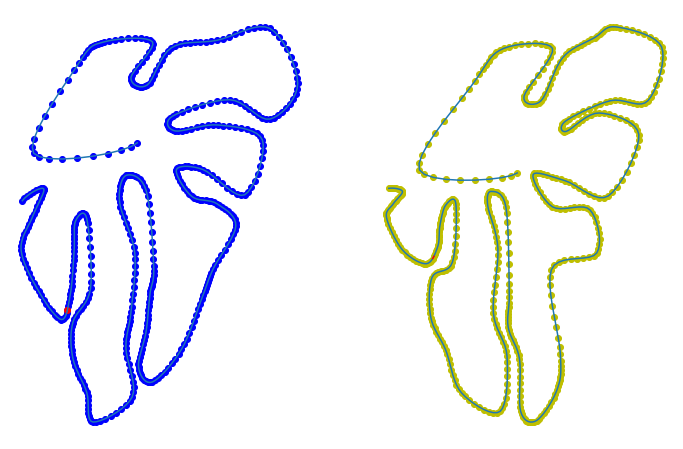

49 to  50 in curve 1
50 to  50 in curve 2 


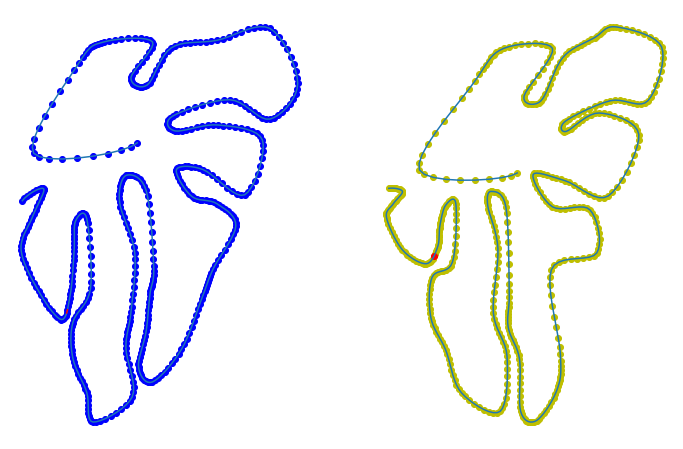

49 to  50 in curve 1
49 to  50 in curve 2 


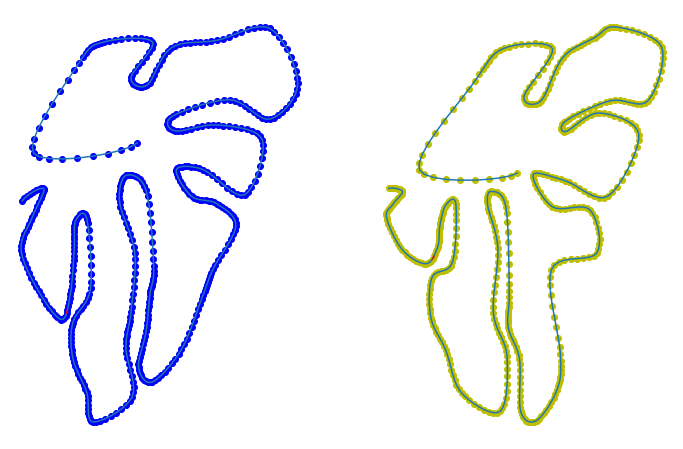

48 to  50 in curve 1
49 to  50 in curve 2 


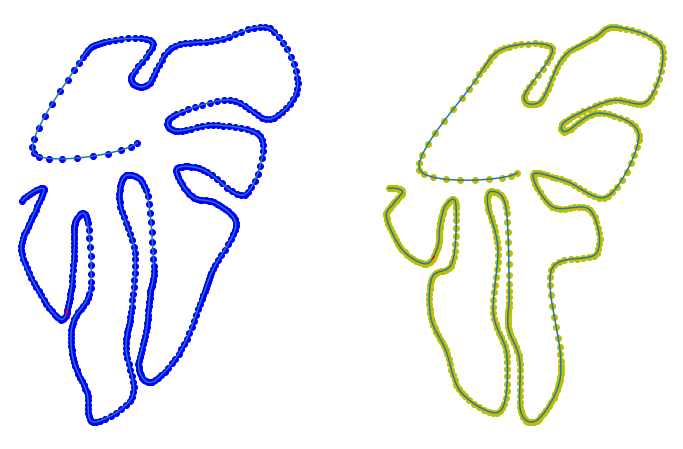

47 to  50 in curve 1
49 to  50 in curve 2 


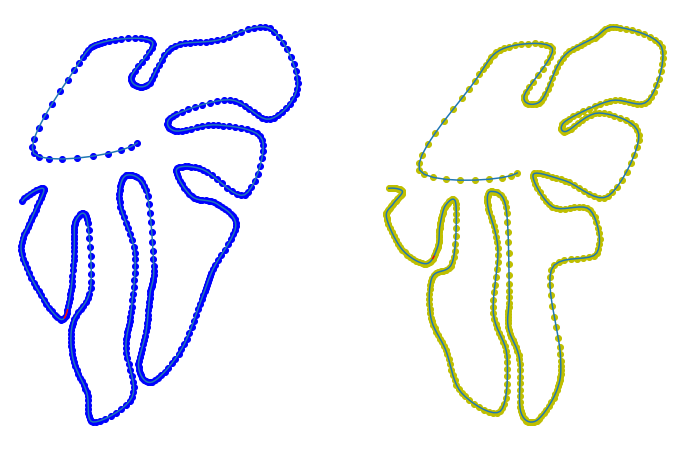

47 to  50 in curve 1
48 to  50 in curve 2 


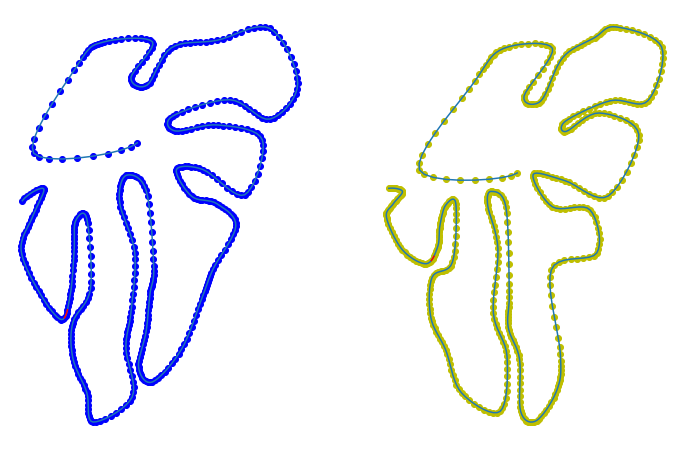

48 to  50 in curve 1
47 to  50 in curve 2 


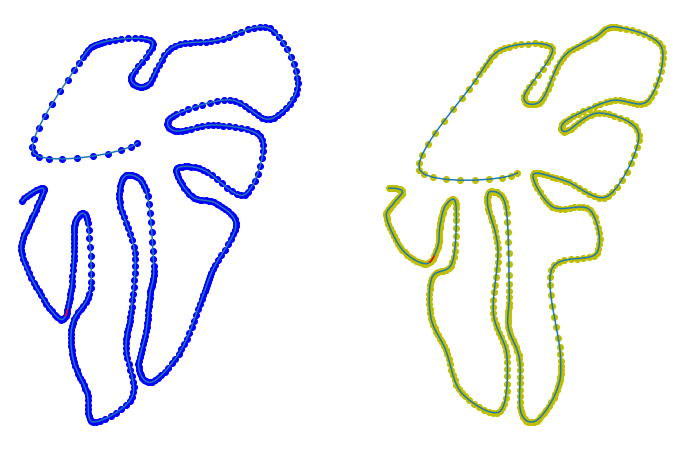

49 to  50 in curve 1
47 to  50 in curve 2 


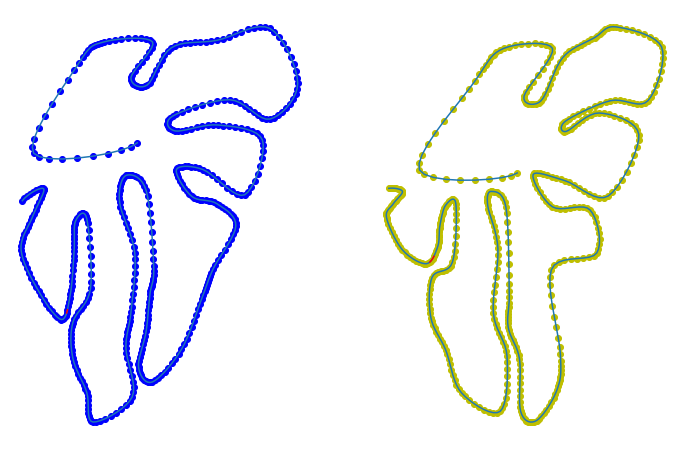

49 to  50 in curve 1
48 to  50 in curve 2 


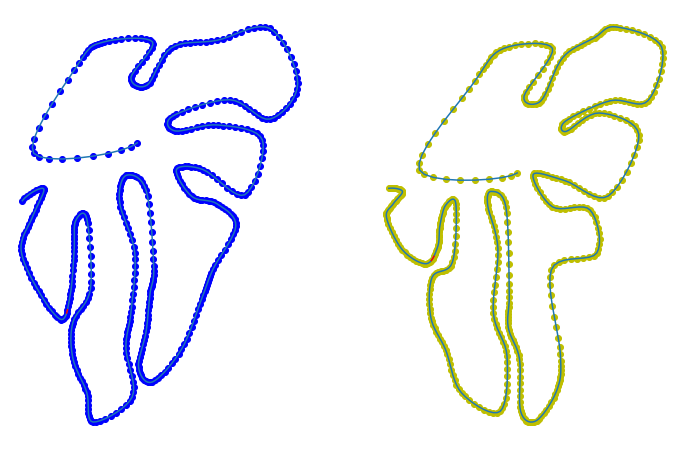

In [221]:
plot_cost_map(50, 50, p1_int, p2_int)

In [222]:
kappa1, _ = get_kappa_and_derivatives(p1_int)
kappa2, _ = get_kappa_and_derivatives(p2_int)

In [223]:
dsi_list = get_segments_from_pt_list(p1_int)
frac = 2.
R = frac*np.mean(dsi_list)

In [224]:

dist = np.zeros((len(p1_int), len(p2_int)))
for i in range(dist.shape[0]):
    for j in range(dist.shape[1]):
        dist[i][j] = np.inf
dist[0][0] = 0.0

predecessor =[[(-1, -1) for i in range(dist.shape[1])] for j in range(dist.shape[0])]
for i in tqdm(range(1,dist.shape[0])):
    
    for j in range(1, dist.shape[1]):
        
        options = []
        str_tup_list, end_tup_list = get_tup_list(i, j)
        for (str_tup, end_tup) in zip(str_tup_list, end_tup_list):
            i1, i2 = str_tup
            j1, j2 = end_tup
            cost = matching_cost(i1, i2, j1, j2, p1_int, p2_int, kappa1, kappa2)
            options.append(dist[i1][j1] + cost)
            
        trace_index = np.argmin(options)        
        (st1, st2), (et1, et2) = str_tup_list[trace_index], end_tup_list[trace_index]
        predecessor[st2][et2] = (st1, et1)        
        dist [i][j] = min(options)

def get_matches(dist, predecessor):

    src1, src2 = dist.shape[0]-1, dist.shape[1]-1
    #c = 0
    global_path = [(src1, src2)]
    while((src1, src2) != (0, 0)):
        global_path.append(predecessor[src1][src2])
        src1, src2 = predecessor[src1][src2]
        #c = c+1
        #if c > 2500:
        #    break
    return global_path


def plot_matches(p1_int, p2_int, global_path, offset, nstart, npts):
    p1_x , p1_y = p1_int[:, 0] + offset, p1_int[:, 1]
    f , a = plt.subplots(1, 1, figsize = (16 , 8)) 
    a.invert_yaxis()
    a.scatter(p2_int[:, 0], p2_int[:, 1], c = "y")
    a.scatter(p1_x, p1_y, c = "r")
    a.set_axis_off()

    arr_p = {"width": 1e-6, "head_width":1e-4}
    for (m1, m2) in global_path[nstart:nstart+npts]:
        a1x, a1y = p1_x[m1-1], p1_y[m1-1]
        dx, dy = p2_int[m2-1][0] - a1x, p2_int[m2-1][1] - a1y
        a.arrow(a1x, a1y, dx, dy, alpha = 0.25, fc = "red", **arr_p )
    plt.show()


100%|██████████| 468/468 [03:55<00:00,  1.99it/s]


In [225]:
dist

array([[  0.        ,          inf,          inf, ...,          inf,
                 inf,          inf],
       [         inf,   2.21682746,   2.2543141 , ..., 786.23182801,
        789.90213795, 792.27753371],
       [         inf,   2.92857623,   3.49821986, ..., 780.70340852,
        784.37371847, 786.74911422],
       ...,
       [         inf, 769.18683419, 764.26737215, ..., 234.67381955,
        237.61109136, 238.63697876],
       [         inf, 772.81583269, 767.89637064, ..., 235.46357138,
        235.12749859, 236.5804252 ],
       [         inf, 775.30597092, 770.38650888, ..., 233.42251615,
        236.58021364, 235.63585628]])

In [230]:
global_path = get_matches(dist, predecessor)

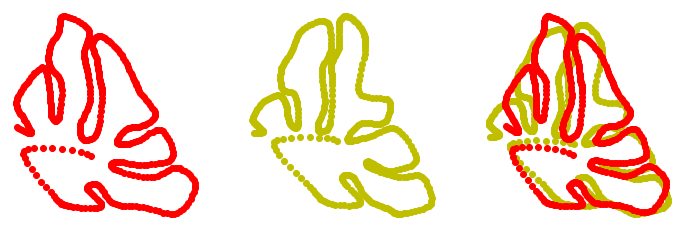

In [227]:
plot_points(p1_int, p2_int)

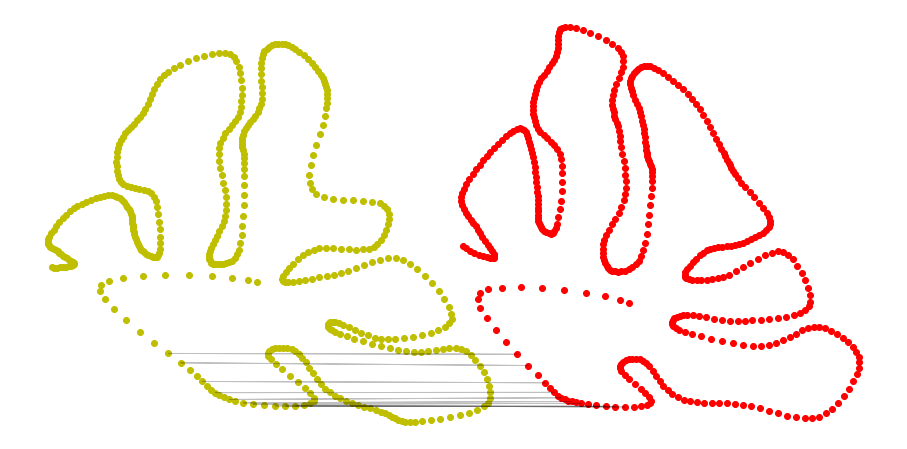

In [232]:
plot_matches(p1_int, p2_int, global_path, 80, 10, 10)

In [234]:
len(global_path), len(p1_int), len(p2_int)

(277, 469, 469)

In [265]:
import importlib
importlib.reload(TPS)

<module 'tps_utils' from '/Users/ranjak/Downloads/jaxreg/tps_utils.py'>

In [271]:
n_sample = 100

global_path = np.asarray(global_path)
p1_index = global_path[:, 0]
p2_index = global_path[:, 1]
p1_pts = p1_int[p1_index]
p2_pts = p2_int[p2_index]

c =list(zip(p1_pts, p2_pts))
cPt = random.sample(c, n_sample)
p1_pts, p2_pts = zip(*cPt)
p1_pts = np.asarray(p1_pts)
p2_pts = np.asarray(p2_pts)
"""plt.scatter(p1_pts[:, 0], p1_pts[:, 1], c ="r")
plt.scatter(p2_pts[:, 0], p2_pts[:, 1], c ="y")"""

'plt.scatter(p1_pts[:, 0], p1_pts[:, 1], c ="r")\nplt.scatter(p2_pts[:, 0], p2_pts[:, 1], c ="y")'

In [272]:
coordinates = TPS.Coordinates([0, 120, 0, 120])
tps = TPS.ThinPlateSpline(coordinates, p1_pts, p2_pts, fix, mov)

In [273]:
params1 = tps.fit(lmatrix = False)
warpf = tps.warp(params1)

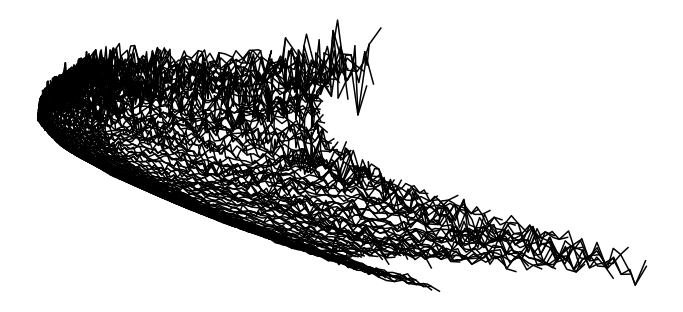

In [274]:
show_warp_field(warpf, plot_separately = False, interval = 2, size = (12, 6))

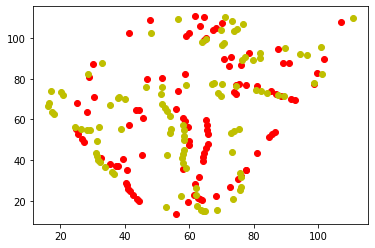

In [276]:
plt.scatter(p1_pts[:, 0], p1_pts[:, 1], c ="r")
plt.scatter(p2_pts[:, 0], p2_pts[:, 1], c ="y")

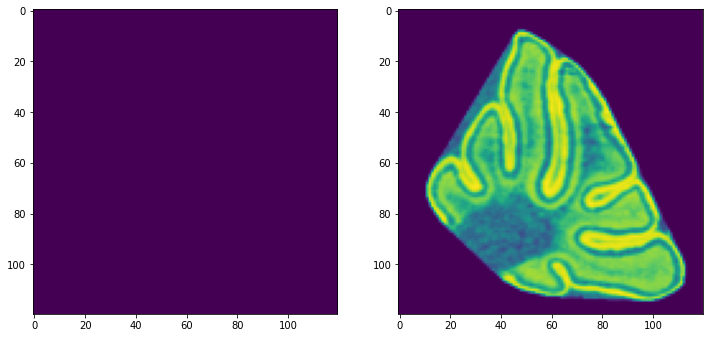

In [275]:
mv = ndi.map_coordinates(mov, warpf, order = 1)
f, a = plt.subplots(1 , 2, figsize = (12, 6) )
a[0].imshow(mv.T)
a[1].imshow(fix)
plt.show()